## Setup
For repeatable experiments we have to set random seeds for anything using random number generation - this means numpy and random as well! It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting torch.backends.cudnn.enabled = False.

Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [1]:
import torch
import torchvision

random_seed = 13
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Load Data
PyTorch's DataLoader contain a few interesting options other than the dataset and batch size. For example we could use num_workers > 1 to use subprocesses to asynchronously load data or using pinned RAM (via pin_memory) to speed up RAM to GPU transfers. But since these mostly matter when we're using a GPU we can omit them here.

Now let's take a look at some examples. We'll use the test_loader for this.

In [2]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

## Let's look!
Ok let's see what one test data batch consists of.

In [4]:
example_data.shape

torch.Size([1000, 1, 28, 28])

## Visualise it!
So one test data batch is a  tensor of shape: . This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.

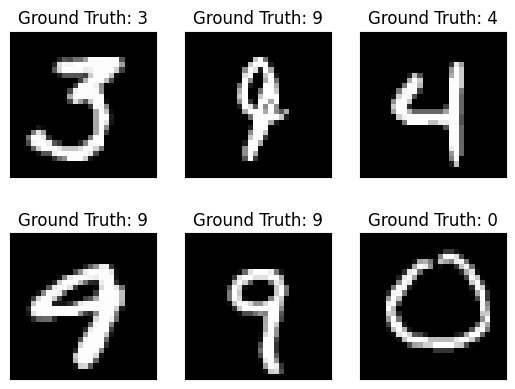

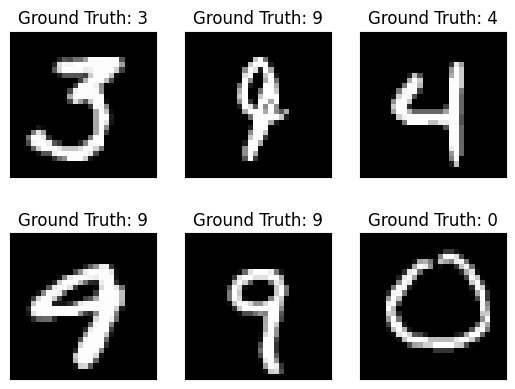

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Build the model
Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

## Set up optimizer!
Broadly speaking we can think of the torch.nn layers as which contain trainable parameters while torch.nn.functional are purely functional. The forward() pass defines the way we compute our output using the given layers and functions. It would be perfectly fine to print out tensors somewhere in the forward pass for easier debugging. This comes in handy when experimenting with more complex models. Note that the forward pass could make use of e.g. a member variable or even the data itself to determine the execution path - and it can also make use of multiple arguments!

Now let's initialize the network and the optimizer.

In [8]:
learning_rate = 0.01
momentum = 0.5

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Note: If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. network.cuda(). It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

## Training the model
Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The backward() call we now collect a new set of gradients which we propagate back into each of the network's parameters using optimizer.step(). For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd (highly recommended).

We'll also keep track of the progress with some printouts. In order to create a nice training curve later on we also create two lists for saving training and testing losses. On the x-axis we want to display the number of training examples the network has seen during training. 

In [9]:
n_epochs = 5
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## Create train step
We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters. Can you guess what our accuracy might look like for this case?

In [10]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict). 

## Create test step!
Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using the context manager no_grad() we can avoid storing the computations done producing the output of our network in the computation graph.

## Train the model!
Time to run the training! We'll manually add a test() call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [12]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140686
Train Epoch: 1 [12160/6

## Visualise the result! 
Time to have a look at how the NN performs and observe what the accuracy achieved represents. 


Test set: Avg. loss: 0.0741, Accuracy: 9785/10000 (98%)



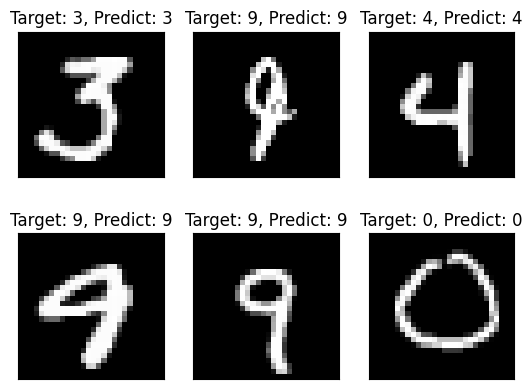

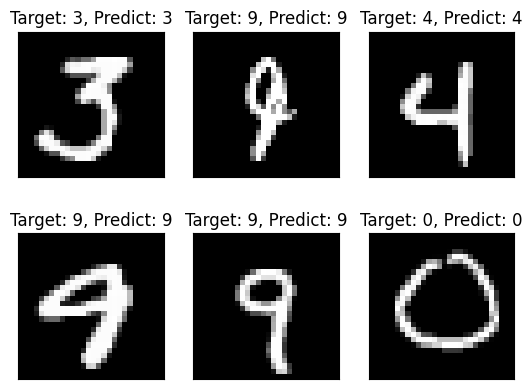

In [15]:
import matplotlib.pyplot as plt

test()
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  output = network(example_data[i])
  pred = output.data.max(1, keepdim=True)[1]
  plt.title("Target: {}, Predict: {}".format(example_targets[i], pred.item()))
  plt.xticks([])
  plt.yticks([])
fig